# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [118]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# импортируем библиотеки

In [119]:
data = pd.read_csv("/datasets/real_estate_data.csv",  sep = "\t")
data.head(5)
# даем название таблице, указываем в качестве разделителя знак табуляции и  открываем первые строки таблицы

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [120]:
data.info() # смотрим общую информацию о таблице

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

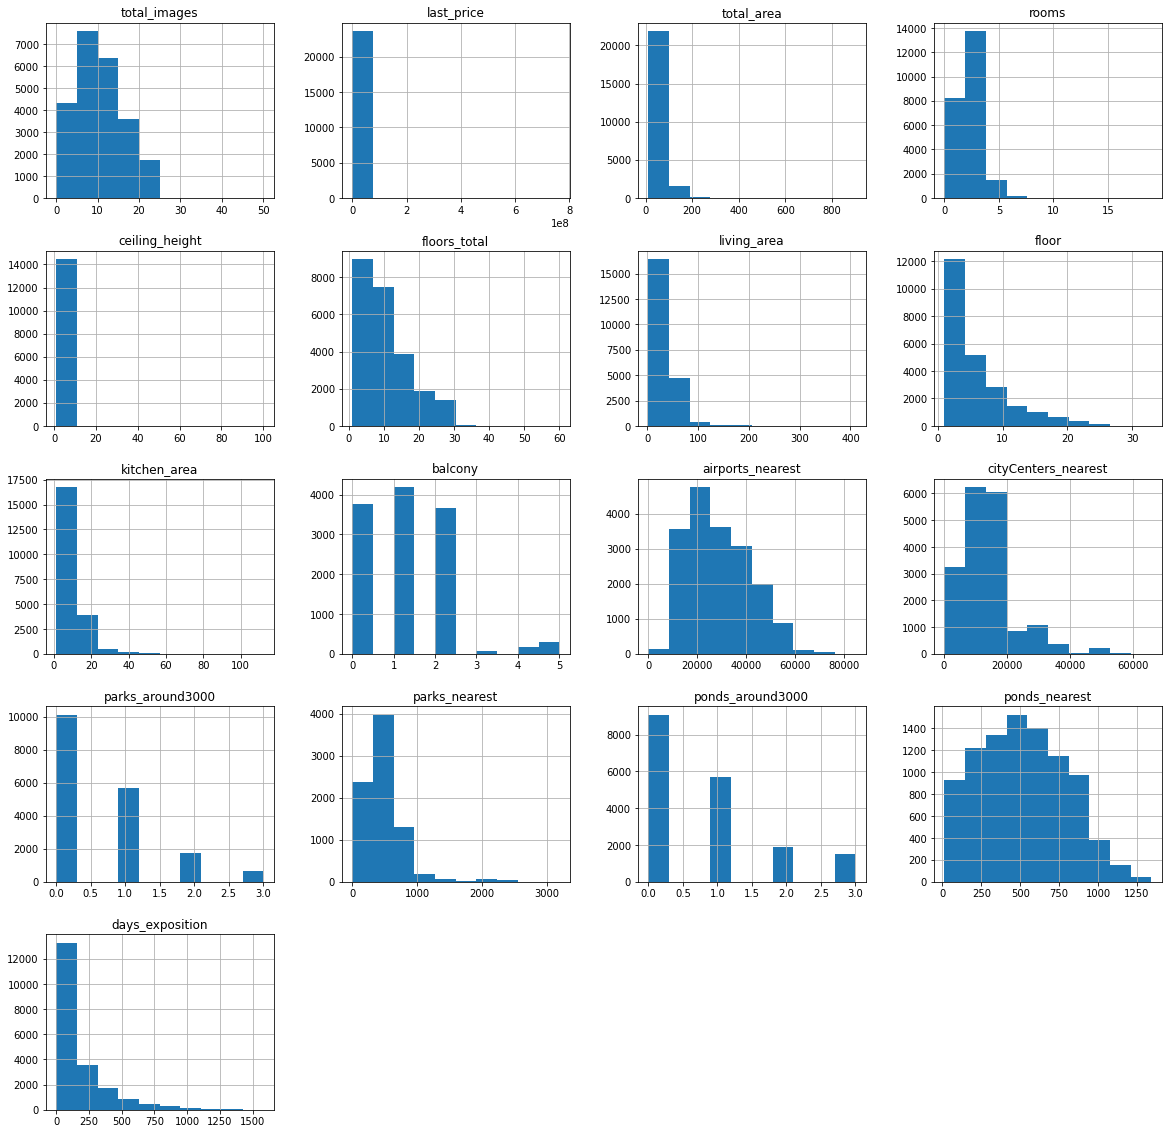

In [121]:
data.hist(figsize=(20, 20)) 
plt.show()
#Cтроим гистограмму для всех числовых значений. анализируем полученную информацию

In [122]:
data.isna().sum() # смотрим на наличие пропусков в столбцах

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [123]:
pd.DataFrame(round(data.isna().mean()*100,1)).style.background_gradient('coolwarm')
# посмотрим долю пропусков

,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,38.800000
floors_total,0.400000
living_area,8.000000
floor,0.000000
is_apartment,88.300000


Пропущены значения в следующих столбцах: "Высота потолка", "Всего этажей", "Жилая площадь", "Это Квартира", "Балкон", "Место нахождения", "Близость к аэропорту", "Близость к центру", "Количество парков в радиусе 3000 м", "Расстояние до ближайшего парка", "Пруды в радиусе 3000", "Расстояние до ближайшего пруда", "Количество дней объявлению"

In [124]:
data.duplicated().sum() # проверяем наличие явных дубликатов

0

В первую очередь займемся пропущенными значениями, заменим пропуски медианными значениями, удалим неявные дубликаты, удалим подозрительно выбивающиеся занчения, а где-то проигнорируем пропуски

### Предобработка данных. Общий вывод

In [125]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S') 
#меняем формат даты

In [126]:
data.head(3) #проверяем

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.7,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0


In [127]:
data["balcony"] = data["balcony"].fillna(0).astype('int') # меняем пропуски в графе "Балконы" на нулевые значения и переводим в целые числа

Изменили тип значения, чтобы исключить нецелое количество балконов

In [128]:
data['balcony'].isna().sum() # проверяем количество пропусков в графе "Балконы"

0

In [129]:
data["ceiling_height"].unique() # проверяем уникальные значения в гарфе "Высота потолков"

array([  2.7 ,    nan,   3.03,   2.5 ,   2.67,   2.56,   3.05,   2.75,
         2.6 ,   2.9 ,   2.8 ,   2.55,   3.  ,   2.65,   3.2 ,   2.61,
         3.25,   3.45,   2.77,   2.85,   2.64,   2.57,   4.15,   3.5 ,
         3.3 ,   2.71,   4.  ,   2.47,   2.73,   2.84,   3.1 ,   2.34,
         3.4 ,   3.06,   2.72,   2.54,   2.51,   2.78,   2.76,  25.  ,
         2.58,   3.7 ,   2.52,   5.2 ,   2.87,   2.66,   2.59,   2.  ,
         2.45,   3.6 ,   2.92,   3.11,   3.13,   3.8 ,   3.15,   3.55,
         3.16,   3.62,   3.12,   2.53,   2.74,   2.96,   2.46,   5.3 ,
         5.  ,   2.79,   2.95,   4.06,   2.94,   3.82,   3.54,   3.53,
         2.83,   4.7 ,   2.4 ,   3.38,   3.01,   5.6 ,   3.65,   3.9 ,
         3.18,   3.35,   2.3 ,   3.57,   2.48,   2.62,   2.82,   3.98,
         2.63,   3.83,   3.52,   3.95,   3.75,   2.88,   3.67,   3.87,
         3.66,   3.85,   3.86,   4.19,   3.24,   4.8 ,   4.5 ,   4.2 ,
         3.36,  32.  ,   3.08,   3.68,   3.07,   3.37,   3.09,   8.  ,
      

In [130]:
data.query('8.3>ceiling_height>2.3')["ceiling_height"].median() 
# определяем медианные значения высоты потолка без учета аномальных

2.65

In [131]:
data.loc[data['ceiling_height'] < 2, 'ceiling_height'] = 2.65 # меняем аномально низкие значения высоты потолка на медианные

In [132]:
data.loc[data['ceiling_height'] > 8.3, 'ceiling_height'] = 2.65 # меняем аномально высокие значения высоты потолка на медианные

In [133]:
data['ceiling_height'] = data['ceiling_height'].fillna(2.65) # меняем пропуски на медианные значения

In [134]:
data['ceiling_height'].isna().sum() # проверяем количество пропусков в столбце "Высота потолков"

0

Пропущенные значения высоты потолка можно заменить медианными значениями, исключив аномально низкие значения ниже 2.3, а также выше 8.3. Можно, конечно, предположить, что 32 - это 3.2, но достоверно этого мы не знаем, из-за малого количества таких значений, можно пренебречь  этими даными и не учитывать их. Высота в 2.3, нверное все-таки допустима, несмотря на то, что нормы высоты потолка 2.5

In [135]:
data["living_area"].describe()
# посмотрим значения жилой площади

count    21796.000000
mean        34.457852
std         22.030445
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64

In [136]:
data.loc[data["living_area"]<5, "living_area" ] = None 

In [137]:
data['living_area'].isna().sum() # проверяем количество пропусков

1907

Меняем аномально низкие значения жилой площади (менее 5 м) на пропуски. Удалять строки или менять на медианное значение нельзя, так как это отразится на общих значениях. 1907 - это 8% от всех значений

In [138]:
data['is_apartment'].unique() # смотрим какие есть уникальные значение в столбце 'is_apartment'

array([nan, False, True], dtype=object)

In [139]:
data['is_apartment'] = data['is_apartment'].fillna(False) # заменим пропуски на False

In [140]:
data['kitchen_area'].min() # проверяем минимальное значение "площадь кухни"

1.3

In [141]:
data.loc[data["kitchen_area"]<5, "kitchen_area" ] = None # маловероятно, что кухня может быть менее 5 метров - меняем на пропуск

In [142]:
data["kitchen_area"] = data["kitchen_area"].fillna(0)

Меняем пропуски и значения кухни менее 5 м. на 0. В таблице есть студии, в которых кухня совмещена с комнатой

In [143]:
data['locality_name'].unique() # смотрим какое количество уникальных значений в столбце


array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [144]:
 data['locality_name'].nunique() # считаем уникальные названия

364

In [145]:
data['locality_name'] = data['locality_name'].str.lower() # переводим все значения в нижний регистр

In [146]:
data['locality_name'] = data.locality_name.str.replace('поселок городского типа', 'поселок')
data['locality_name'] = data.locality_name.str.replace('городской поселок', 'поселок')
data['locality_name'] = data.locality_name.str.replace('деревня кудрово', 'кудрово')
data['locality_name'] = data.locality_name.str.replace('поселок мурино', 'мурино')
data['locality_name'] = data.locality_name.str.replace('поселок любань', 'любань')
# избавляемся от найденных дубликатов

In [147]:
data = data.apply(lambda x: x.replace({'поселок городского типа':'посeлок', 'городской поселок': 'посёлок',\
                                       'деревня кудрово': 'кудрово', 'поселок мурино': 'мурино', \
                                       'поселок любань': 'любань', "посёлок" : "поселок" }, regex=True))

len(data.locality_name.unique())
# избавляемся от найденных дубликатов

337

In [148]:
data = data.dropna(subset=['locality_name']) # удаление пропусков из столбца с населенным пунктом

Количество пропущенных значений в столбце с населенным пунктом равнялось 49. Название населенного пункта очень важный параметр, но так как пропущенные значения всего в 0.2% данных, то пропущенные данные можно удалить

In [149]:
data["airports_nearest"].min()# проверяем минимальное расстояние до аэропорта

0.0

In [150]:
data.loc[data['airports_nearest'] == 0, 'airports_nearest'] = None 
# меняем нулевое значение расстояния до аэропорта на пропущенное

In [151]:
data["airports_nearest"].min() #проверяем

6450.0

Скорее всего нулевое значение расстояние до аэропорта вызвано ошибкой, а следующее по возрастанию расстояние в 6 км реально

In [152]:
data = data.rename(columns={'cityCenters_nearest':'city_centers_nearest'}) 
#приводим к нижнему регистру название столбца

In [153]:
data = data.rename(columns={'parks_around3000':'parks_around', 'ponds_around3000':'ponds_around'}) # переименовываем столбцы

In [154]:
data["parks_around"].unique() # проверяем какие уникальные значения в столбце 

array([ 1.,  0.,  2., nan,  3.])

In [155]:
data["parks_around"] = data["parks_around"].fillna(0).astype('int') 
# меняем пропуски на нулевые значения

Изменили тип на целое количество - так как не може быть нецелого количества парков

In [156]:
data["ponds_around"].unique() # проверяем какие уникальные значения в столбце 

array([ 2.,  0.,  3.,  1., nan])

In [157]:
data["ponds_around"] = data["ponds_around"].fillna(0).astype('int') # меняем пропуски на нулевые значения, так как очень высока 
#вероятность того, что водоемов  в радиусе 3км нет, и здесть просто  забыли это указать Меняем на данные на целые значения

Изменили тип на целое количество - так как не може быть нецелого количества водоемов

In [158]:
data["days_exposition"].isna().sum() # считаем количество пропусков

3180

Прпусков в столбце "days_exposition" довольно таки много, замещать ничем не будем, так как объявление по всей видимости еще актуально, если смотреть по дате  размещения объявления

In [159]:
data['floors_total'].isna().sum()

85

In [43]:
data = data.dropna(subset=['floors_total']) # удаляем пропуски в графе с высотой дома

In [44]:
data.floors_total = data.floors_total.astype('int') # меняем тип данных в высоте дома

Количество пропусков в графе "floors_total" 85 - это около 0.3% от всех данных, поэтому эти пропуски можно удалить

Данные в столбце "parks_nearest" и "ponds_nearest" имеют большое количество пропущенных значений, заменять их чем-то нецелесообразно, потому что на медианном расстоянии может и не оказаться водоема или парка

In [45]:
data.isna().sum() # проверяем на пропуски таблицу после предобработки

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area              1869
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5525
city_centers_nearest     5501
parks_around                0
parks_nearest           15535
ponds_around                0
ponds_nearest           14529
days_exposition          3171
dtype: int64

Вывод. Очень много прорущенных значений. Многие из этих пропущенных значений существенным образом могли бы повлиять на решение о приобретении недвижимости. Небходимо быт более внимательным при обработке и переносе данных

### Посчитайте и добавьте в таблицу новые столбцы

In [46]:
data["price_per_meter"] = data['last_price']/data['total_area'] # расчитываем стоимость 1 кв.м жилья

In [47]:
data["price_per_meter"] = data["price_per_meter"].round(2) # округляем до двух знаков после запятой

In [48]:
print("Максимальная цена за квадратный метр", data["price_per_meter"].max()) # считаем стоимость мин, макс и среднее
print("Минимальная цена за квадратный метр", data["price_per_meter"].min())
print("Средняя цена за квадратный метр", data["price_per_meter"].mean())

Максимальная цена за квадратный метр 1907500.0
Минимальная цена за квадратный метр 111.83
Средняя цена за квадратный метр 99405.8371754721


In [49]:
data["publication_day"] = data['first_day_exposition'].dt.weekday # добавляем столбец с днем недели публикации

In [50]:
data["publication_month"] = data['first_day_exposition'].dt.month # добавляем столбец с месяцем публикации

In [51]:
data["publication_year"] = data['first_day_exposition'].dt.year # добавляем столбец с годом публикации

In [52]:
data["publication_year"].value_counts() # считаем в какой год было больше всeго объявлений

2018    8486
2017    8161
2019    2871
2016    2745
2015    1166
2014     136
Name: publication_year, dtype: int64

С каждым годом количество объявлений увеличиваетися, скорее всего это  связано с популяризацией площадки. Почему меньше объявлений в 2019-м неизвестно - в 2023 м году неизвестно на какую дату актуальна эта таблица

In [53]:
data['type_floor'] = 'другой' # 

In [54]:
data.loc[data['floor'] == 1, 'type_floor'] = 'первый'

In [55]:
data.loc[data['floors_total']/data['floor'] == 1.0, 'type_floor'] = 'последний'

Задали столбец с типом этажа. Изначально установили все значения "другой", потом добавили "первый", потом"последний"

In [56]:
data["type_floor"].value_counts()

другой       17326
последний     3355
первый        2884
Name: type_floor, dtype: int64

Средних этажей больше всего - это и не удивительно.

In [57]:
data["distance_center_km"] = data["city_centers_nearest"]/1000 
# считаем расстоние до центра в километрах, добавляем столбец 

In [58]:
data["distance_center_km"]= data["distance_center_km"].round() # округляем

In [59]:
data.head(5) # проверяем добавление столбцов

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around,ponds_nearest,days_exposition,price_per_meter,publication_day,publication_month,publication_year,type_floor,distance_center_km
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,482.0,2,755.0,NaN,120370.37,3,3,2019,другой,16.0
1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.6,1,False,...,NaN,0,NaN,81.0,82920.79,1,12,2018,первый,19.0
2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.3,4,False,...,90.0,2,574.0,558.0,92785.71,3,8,2015,другой,14.0
3,0,64900000.0,159.0,2015-07-24,3,2.65,14,NaN,9,False,...,84.0,3,234.0,424.0,408176.10,4,7,2015,другой,7.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,112.0,1,48.0,121.0,100000.00,1,6,2018,другой,8.0


Добавили необходимые столбцы для дальнейшего исследования

### Проведите исследовательский анализ данных

Изучим площадь квартир, высоту потолков, количество комнат и стоимость объектов

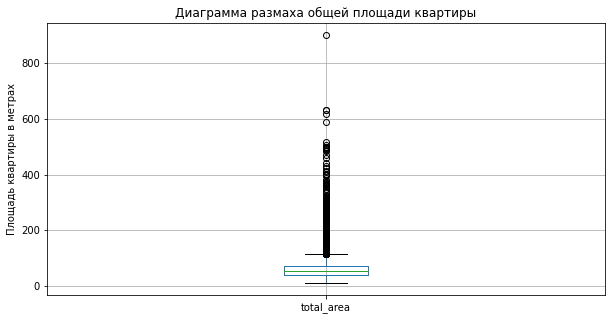

In [166]:
data.boxplot(column=['total_area'], figsize=(10,5), grid=True)
plt.ylabel('Площадь квартиры в метрах')
plt.title('Диаграмма размаха общей площади квартиры')
plt.show()
# строим диаграмму размаха общей площади квартиры

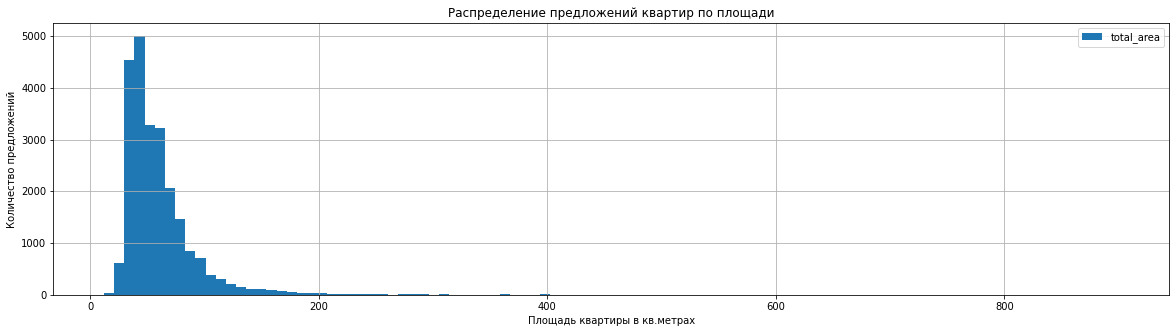

In [61]:
data.plot(kind = "hist", y = 'total_area', bins=100,  figsize=(20,5), grid = True, title = "Распределение предложений квартир по площади") 
plt.xlabel('Площадь квартиры в кв.метрах')
plt.ylabel('Количество предложений')
plt.show()
# строим гистограмму общей площади квартиры

In [160]:
data["total_area"].describe()

count    23650.000000
mean        60.329069
std         35.661808
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64

Проанализировав гистограмму и ящик с усами убрем выбивающиеся значения, а именно превышающие 100 кв. м и менее 20 

In [161]:
good_data = data.query('20 < total_area < 100')

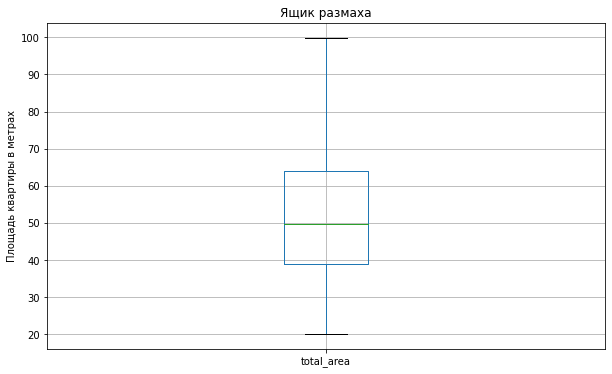

In [165]:
good_data.boxplot(column=['total_area'], figsize=(10,6), grid=True) 
plt.ylabel('Площадь квартиры в метрах')
plt.title('Ящик размаха')
plt.show()

# строим ящик размаха, после того, как убрали выбросы

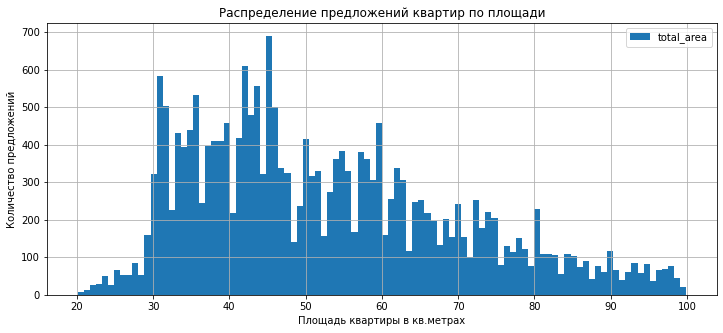

In [65]:
good_data.plot(kind = "hist", y = 'total_area', bins=100,  figsize=(12,5), grid = True, title = "Распределение предложений квартир по площади") 
plt.xlabel('Площадь квартиры в кв.метрах')
plt.ylabel('Количество предложений')
plt.show()
# строим гистограмму общей площади квартиры, после удаления выбросов

В основном в продаже квартиры площадью около 50 м

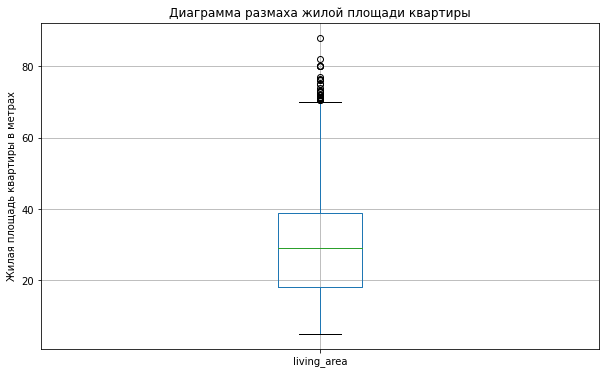

In [167]:
good_data.boxplot(column=['living_area'], figsize=(10,6), grid=True)
plt.ylabel('Жилая площадь квартиры в метрах')
plt.title('Диаграмма размаха жилой площади квартиры')
plt.show()

# строим диаграмму размаха жилой площади квартиры

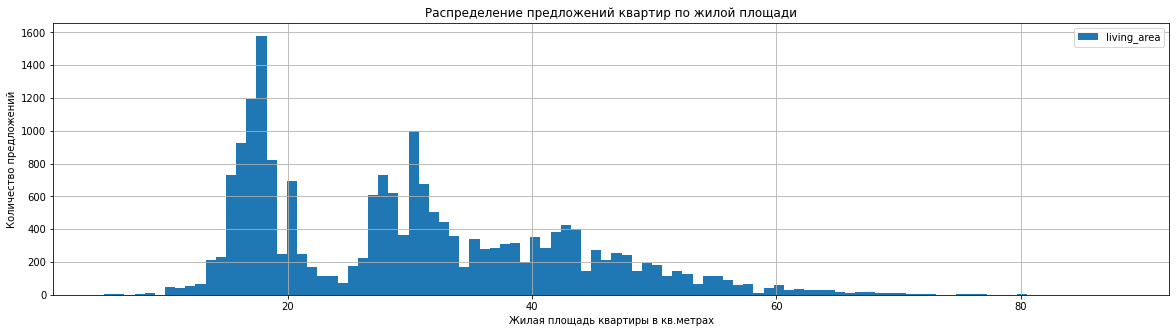

In [67]:
good_data.plot(kind = "hist", y = 'living_area', bins=100,  figsize=(20,5), grid = True, title = "Распределение предложений квартир по жилой площади") 
plt.xlabel('Жилая площадь квартиры в кв.метрах')
plt.ylabel('Количество предложений')
plt.show()
 # строим гистограмму жилой площади

In [68]:
good_data = data.query('10<living_area < 60') # отсекаем выбросы менее 10 и  более 60 кв.м жилой плщади

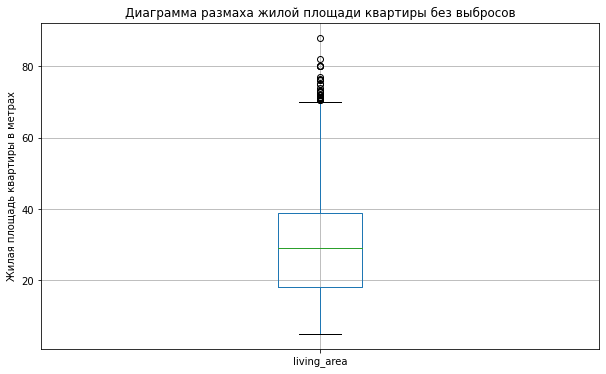

In [168]:
good_data.boxplot(column=['living_area'], figsize=(10,6), grid=True)
plt.ylabel('Жилая площадь квартиры в метрах')
plt.title('Диаграмма размаха жилой площади квартиры без выбросов')
plt.show()

# строим ящик размаха жилой площади без выбросов

Предложения о продаже квартир по прараметру "жилая площадь" распредеелны следующим образом: в основном это 15 кв.м - это соответственно 1к.кв. и чуть менее 30 кв. м - это 2. к.кв. Остальные значения представлены меньше

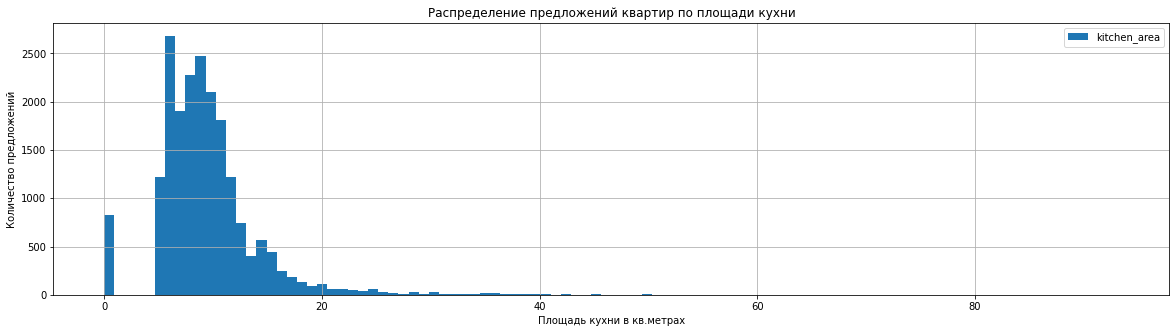

In [70]:
good_data.plot(kind = "hist", y = 'kitchen_area', bins=100,  figsize=(20,5), grid = True, title = "Распределение предложений квартир по площади кухни") 
plt.xlabel('Площадь кухни в кв.метрах')
plt.ylabel('Количество предложений')
plt.show()
# строим гистограмму площади кухни

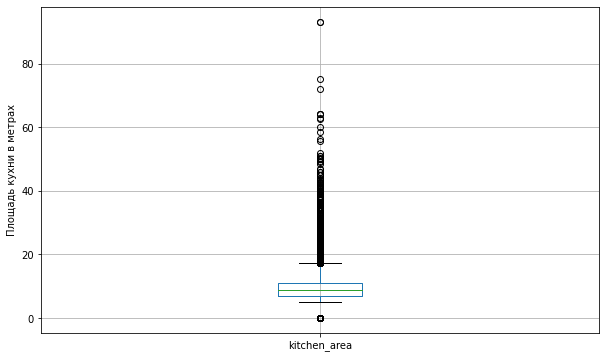

In [71]:
good_data.boxplot(column=['kitchen_area'], figsize=(10,6), grid=True)
plt.ylabel('Площадь кухни в метрах')
plt.title('Диаграмма размаха площади кухни')
plt.show()

# строим диаграмму размаха площади кухни

In [72]:
good_data = data.query('4 <kitchen_area < 18') # отсекаем выбросы с минимальным значением и  более 18 кв.м

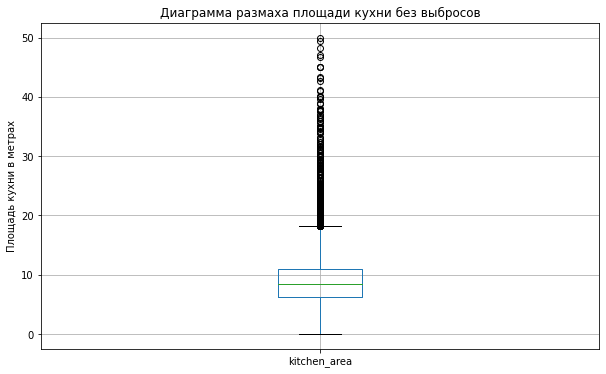

In [169]:
good_data.boxplot(column=['kitchen_area'], figsize=(10,6), grid=True)
plt.ylabel('Площадь кухни в метрах')
plt.title('Диаграмма размаха площади кухни без выбросов')
plt.show()

В основной массе размер кухни составляет от 6 до 12 кв. м. В данной таблице представлено большое количество строк с размером кухни равной 0, это квартиры студии.

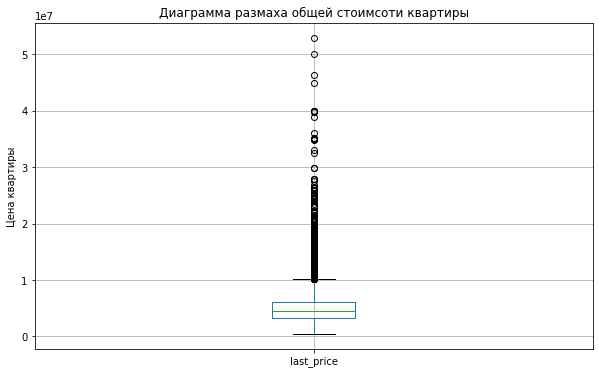

In [170]:
good_data.boxplot(column=['last_price'], figsize=(10,6), grid=True)
plt.ylabel('Цена квартиры')
plt.title('Диаграмма размаха общей стоимсоти квартиры')
plt.show()
# строим диаграмму размаха стоимости квартиры

In [75]:
good_data["last_price"].describe()*0.000001 # анализируем цену, переведя ее в млн.

count      0.019736
mean       5.492654
std        4.272545
min        0.430000
25%        3.400000
50%        4.500000
75%        6.300000
max      130.000000
Name: last_price, dtype: float64

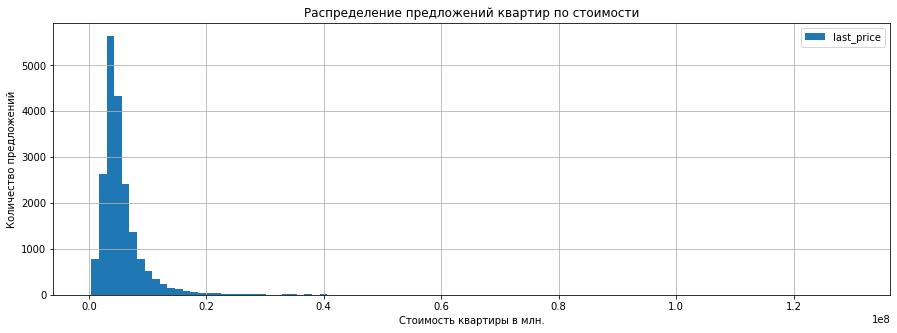

In [76]:
good_data.plot(kind = "hist", y = 'last_price', bins=100,  figsize=(15,5), grid = True, title = "Распределение предложений квартир по стоимости") 
plt.xlabel('Стоимость квартиры в млн.')
plt.ylabel('Количество предложений')
plt.show()
# строим гистограмму стоимости квартиры

In [77]:
good_data = data.query('last_price < 9000000') # отсекаем выбросы более 18 кв.м

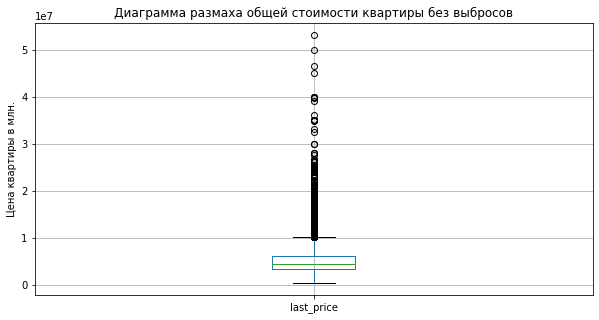

In [171]:
good_data.boxplot(column=['last_price'], figsize=(10,5), grid=True)
plt.ylabel('Цена квартиры в млн.')
plt.title('Диаграмма размаха общей стоимости квартиры без выбросов')
plt.show()


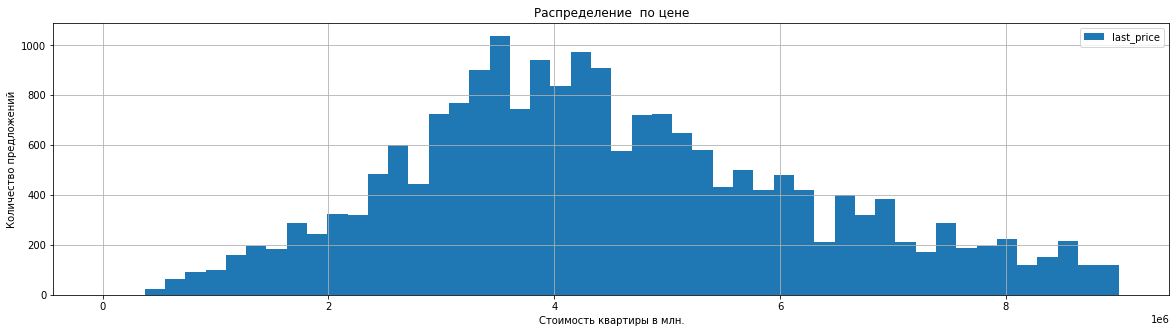

In [79]:
good_data.plot(kind='hist', y='last_price', title='Распределение  по цене',grid=True, bins=50, figsize=(20,5))
plt.xlabel('Стоимость квартиры в млн.')
plt.ylabel('Количество предложений')
plt.show()

Большинство квартир на рынке в диапазоне около 4 млн. Эх...

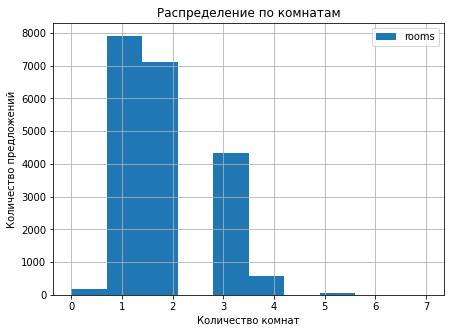

In [80]:
good_data.plot(kind='hist',y='rooms',title='Распределение по комнатам',grid=True, bins=10, figsize=(7,5))
plt.xlabel('Количество комнат')
plt.ylabel('Количество предложений')
plt.show()

В основном в продаже одно и двух комнатные квартиры. Используем для анализа таблицу без учета выбросов в площади квартир свыше 100м.

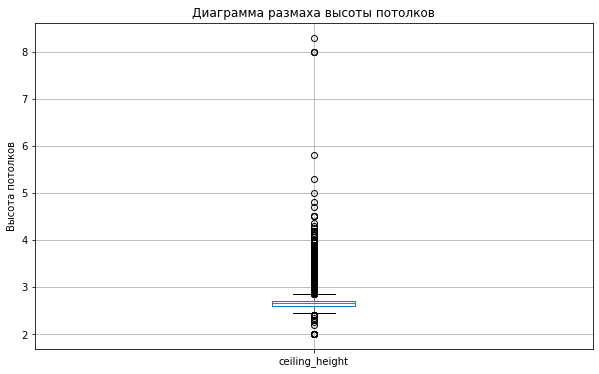

In [172]:
good_data.boxplot(column=['ceiling_height'], figsize=(10,6), grid=True)
plt.ylabel('Высота потолков')
plt.title('Диаграмма размаха высоты потолков')
plt.show()
# строим диаграмму размаха высоты потолков

Text(0, 0.5, 'Количество предложений')

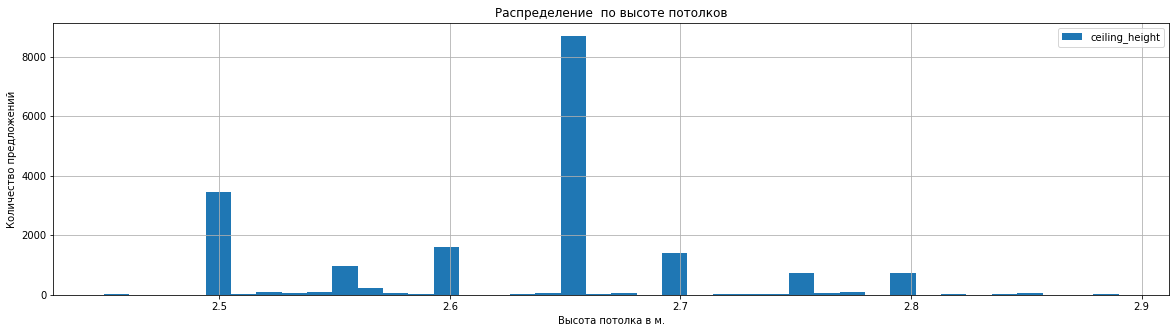

In [82]:
good_data = good_data.query('ceiling_height < 2.9 and ceiling_height > 2.4')
good_data.plot(kind='hist',y='ceiling_height',grid=True, bins=40, figsize=(20,5),title='Распределение  по высоте потолков')
plt.xlabel('Высота потолка в м.')
plt.ylabel('Количество предложений')


Как видно из гистограммы в основном потолки высотой 2.65

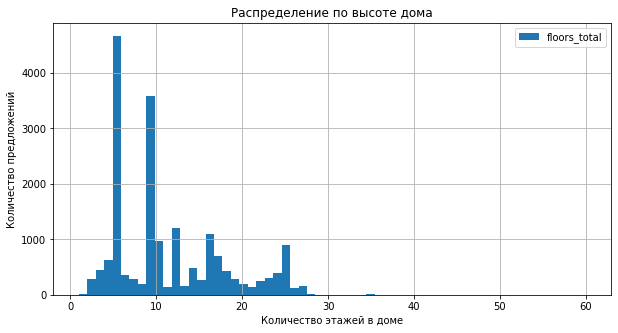

In [83]:
good_data.plot(kind='hist',y='floors_total',grid=True, bins=60, figsize=(10,5),title='Распределение по высоте дома')
plt.xlabel('Количество этажей в доме')
plt.ylabel('Количество предложений')
plt.show()

Количество распределений предложений по высоте дома больше всего 5 этажных домов, чуть меньше - 9 этажные дома

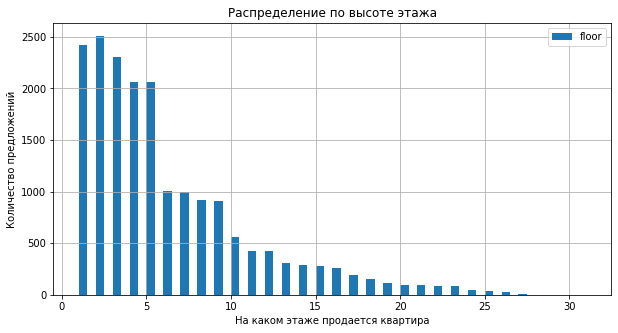

In [84]:
good_data.plot(kind='hist',y='floor',grid=True, bins=60, figsize=(10,5),title='Распределение по высоте этажа')
plt.xlabel('На каком этаже продается квартира')
plt.ylabel('Количество предложений')
plt.show()

Предложения распределены следующим образом с 1по 5й этаж больше всего предложений, в два раза меньше предложений с 6 по 9 в два раза меньше. Это и закономерно, больше всего домов 5 и 9 этажных, как видно из предыдущей гистограммы

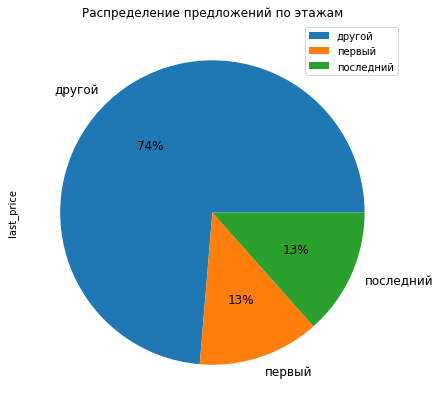

In [85]:
good_data.pivot_table(index='type_floor',values='last_price', aggfunc='count')\
.plot.pie(y='last_price', autopct='%1.0f%%', fontsize=12,figsize=(10,7), title='Распределение предложений по этажам')

plt.show()

Подавляющее большинство квартир расположены на средних этажах. Квартир на первом и послежнем этажах довольно таки мало

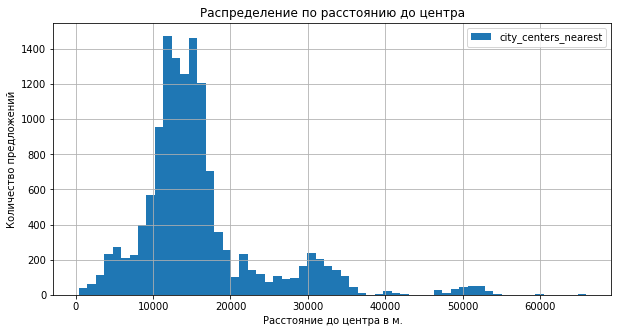

In [86]:
good_data.plot(kind='hist',y='city_centers_nearest',grid=True, bins=60, figsize=(10,5),title='Распределение по расстоянию до центра')
plt.xlabel('Расстояние до центра в м.')
plt.ylabel('Количество предложений')
plt.show()

Больше всего продается квартир на расстоянии от 10 до 14 км от центра. Это и не удивительно, центр ведь маленкий

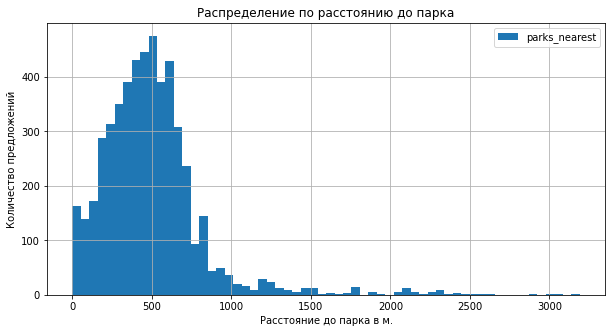

In [87]:
good_data.plot(kind='hist',y='parks_nearest',grid=True, bins=60, figsize=(10,5),title='Распределение по расстоянию до парка')
plt.xlabel('Расстояние до парка в м.')
plt.ylabel('Количество предложений')
plt.show()

В основном парки находятся на расстоянии 500 метров от квартиры

Можно сделать вывод, что большинство квартир продаются в 5 этажных домах на 2-4 этаже, высота потолков около 2.65. Эти дома расположены в радиусе 14 километров от центра города, с парком в пешей доступности

Изучим, как быстро продавались квартиры

In [88]:
good_data["days_exposition"].describe()

count    16565.000000
mean       166.299064
std        203.876452
min          1.000000
25%         42.000000
50%         88.000000
75%        210.000000
max       1580.000000
Name: days_exposition, dtype: float64

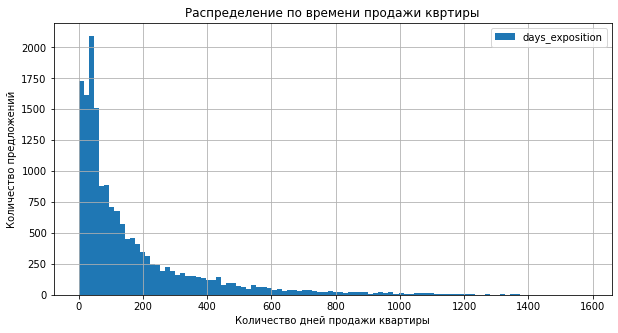

In [89]:
good_data.plot(kind='hist',y='days_exposition',title='Распределение по времени продажи квртиры', grid = True, bins=100, figsize=(10,5))
plt.xlabel('Количество дней продажи квартиры')
plt.ylabel('Количество предложений')
plt.show()

In [90]:
good_data["days_exposition"].median() # считаем медианное время продажи квартиры

88.00000000000001

In [91]:
good_data["days_exposition"].mean() # считаем среднее время продажи квартиры

166.29906429218232

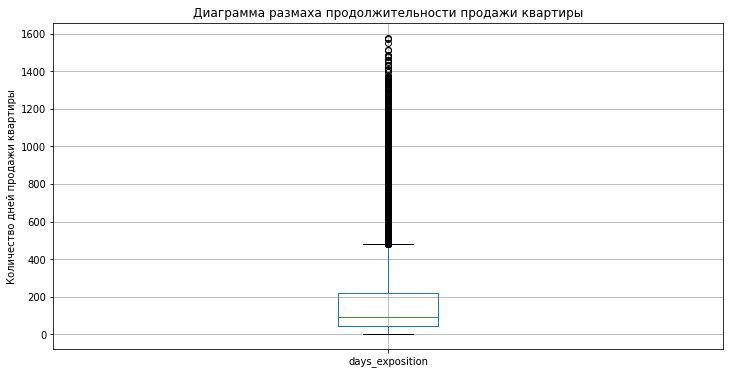

In [175]:
good_data.boxplot('days_exposition', figsize=(12,6))
plt.ylabel('Количество дней продажи квартиры')
plt.title('Диаграмма размаха продолжительности продажи квартиры')
plt.show()
# строим диаграмму размах времени продажи квартиры

In [93]:
good_data_exposition = good_data.query('days_exposition < 200') # отсекаем квартиры с временем продажи более 200 дней

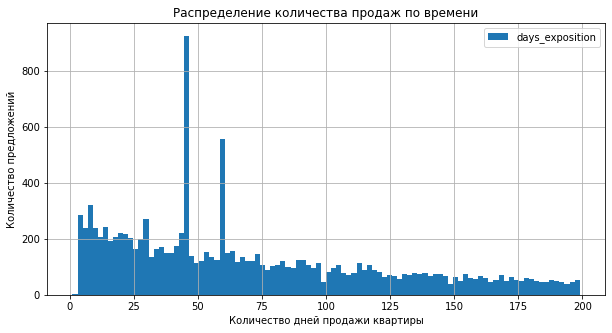

In [94]:
good_data_exposition.plot(kind='hist',y='days_exposition',grid = True, title='Распределение количества продаж по времени', bins=100, figsize=(10,5))
plt.xlabel('Количество дней продажи квартиры')
plt.ylabel('Количество предложений')
plt.show()

Можно сделать вывод, что многие квартиры продаются за два три месяца, остальные продаются за период до года. Со временем квартиры все равно продаются, квартир, которые продаются более двух лет - их ничтожно мало. 

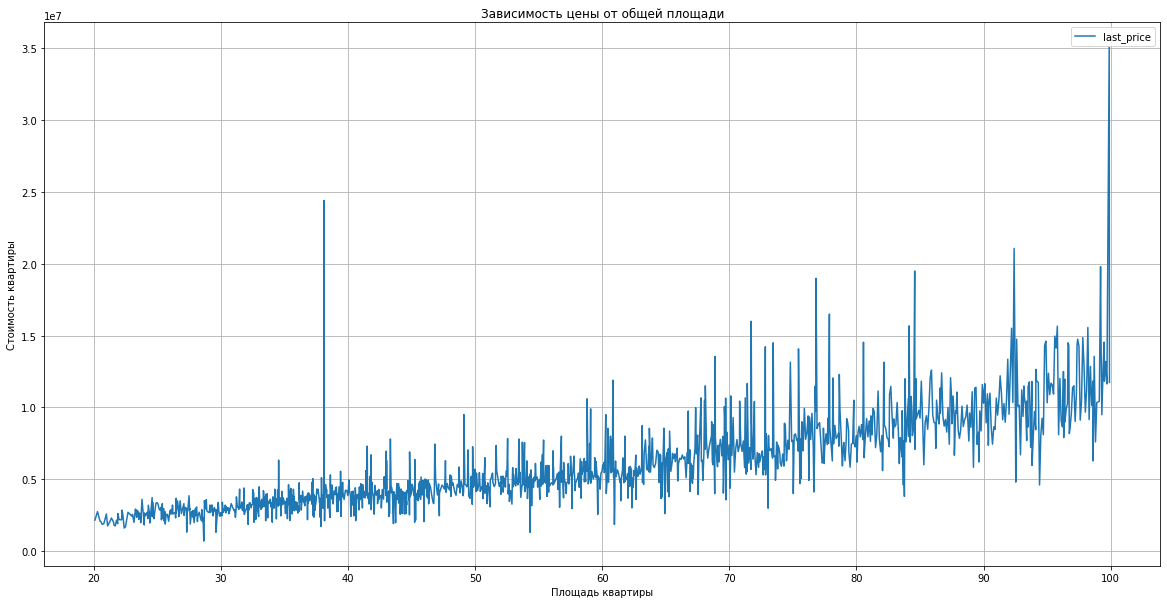

In [179]:
(good_data
    .pivot_table(index='total_area', values=['last_price'])
    .plot(grid=True, figsize=(20, 10), title='Зависимость цены от общей площади'))
plt.xlabel('Площадь квартиры')
plt.ylabel('Стоимость квартиры')
plt.show()

Прослеживается закономерноть - чем больше общая площадь, тем дороже квартира

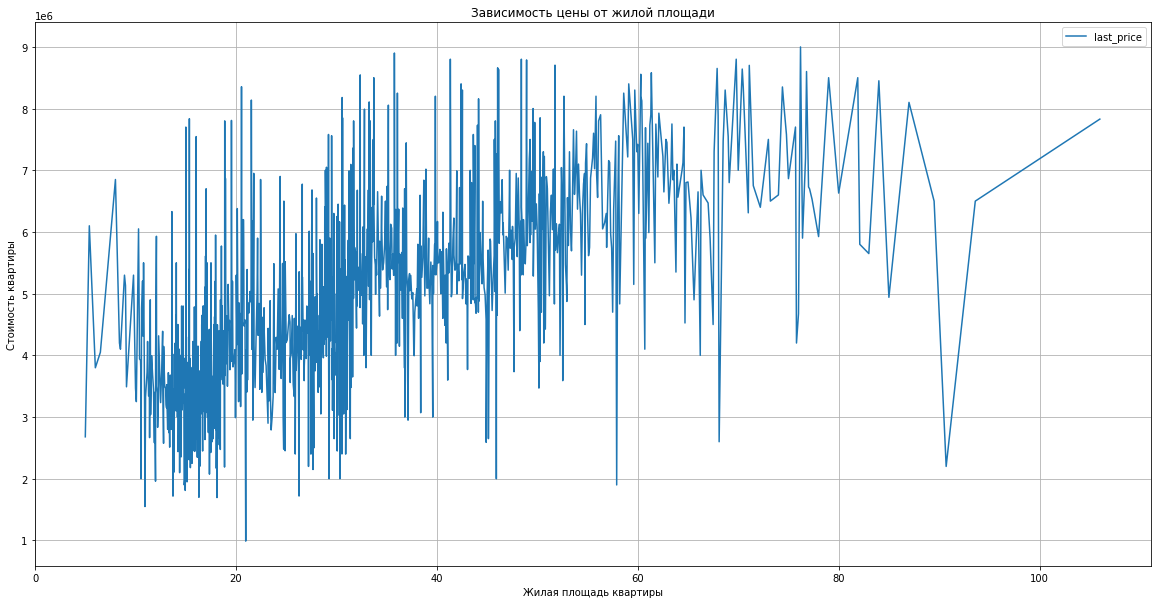

In [96]:
(good_data
    .pivot_table(index='living_area', values=['last_price'])
    .plot(grid=True, figsize=(20, 10),title='Зависимость цены от жилой площади'))
plt.xlabel('Жилая площадь квартиры')
plt.ylabel('Стоимость квартиры')
plt.show()

Здесь зависимость от размера жилой площади есть, но она не такая сильная, как зависимость с общей площадью

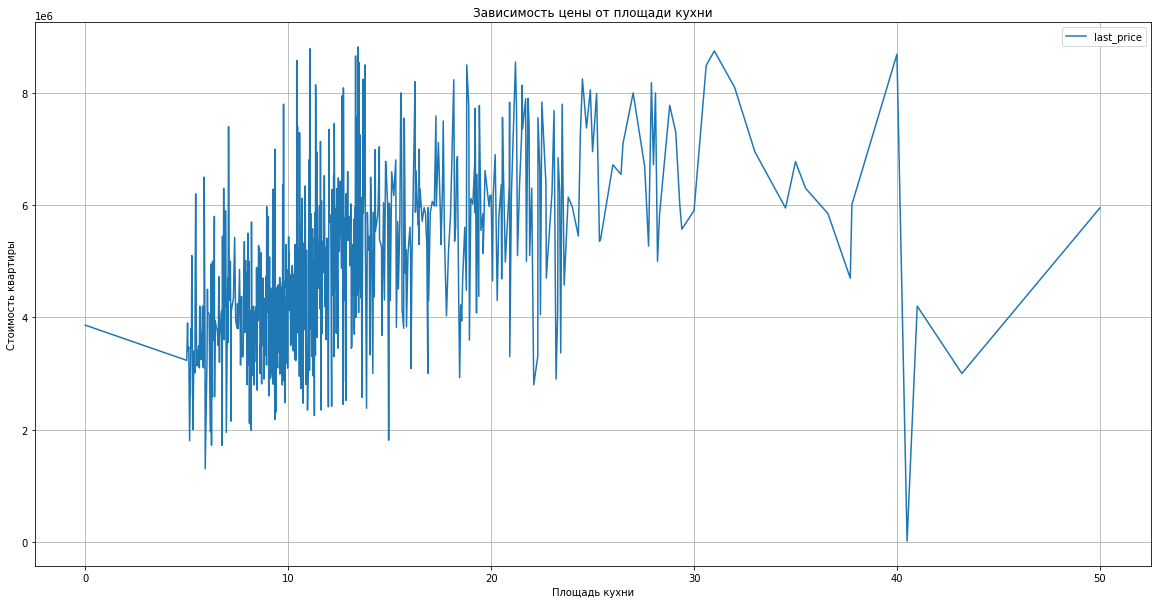

In [97]:
(good_data
    .pivot_table(index='kitchen_area', values=['last_price'])
    .plot(grid=True, figsize=(20, 10),title='Зависимость цены от площади кухни'))
plt.xlabel('Площадь кухни')
plt.ylabel('Стоимость квартиры')
plt.show()

Зависимость цены от размера кухни есть. Большие кухни ценятся

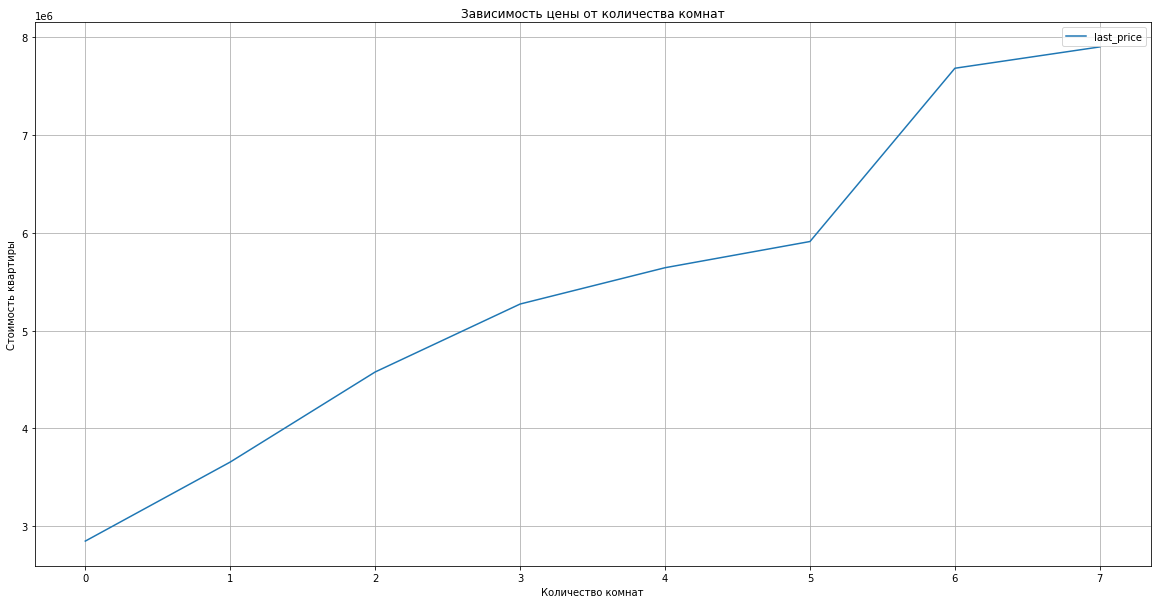

In [98]:
(good_data
    .pivot_table(index='rooms', values=['last_price'])
    .plot(grid=True, figsize=(20, 10),title='Зависимость цены от количества комнат'))
plt.xlabel('Количество комнат')
plt.ylabel('Стоимость квартиры')
plt.show()

Тут вообще все очевидно. Больше комнат - выше цена

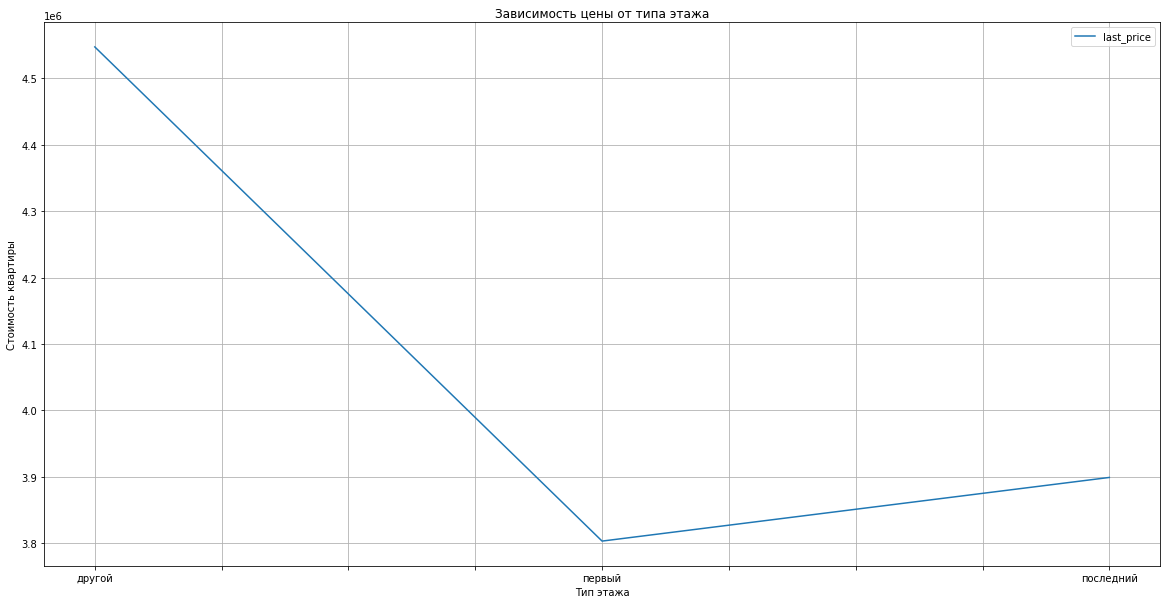

In [99]:
(good_data
    .pivot_table(index='type_floor', values=['last_price'])
    .plot(grid=True, figsize=(20, 10),title='Зависимость цены от типа этажа'))
plt.xlabel('Тип этажа')
plt.ylabel('Стоимость квартиры')
plt.show()

Никто не любит первый этаж. Квартиры на первом этаже самые низкие по стоимости. Последние этажи не намного дороже

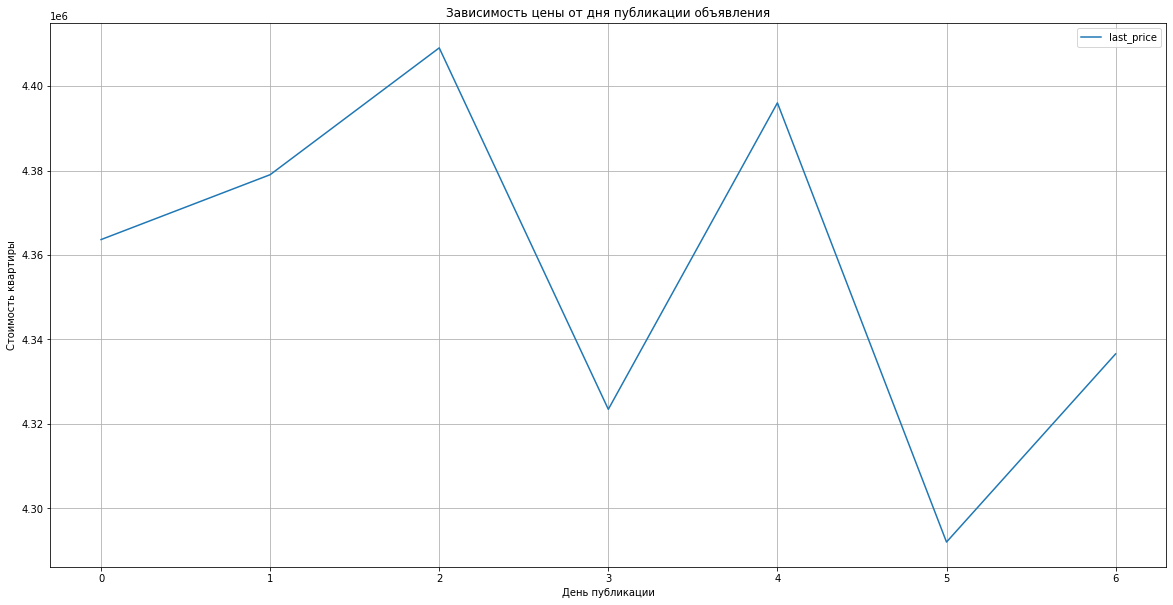

In [100]:
(good_data
    .pivot_table(index='publication_day', values=['last_price'])
    .plot(grid=True, figsize=(20, 10),title='Зависимость цены от дня публикации объявления'))
plt.xlabel('День публикации')
plt.ylabel('Стоимость квартиры')
plt.show()

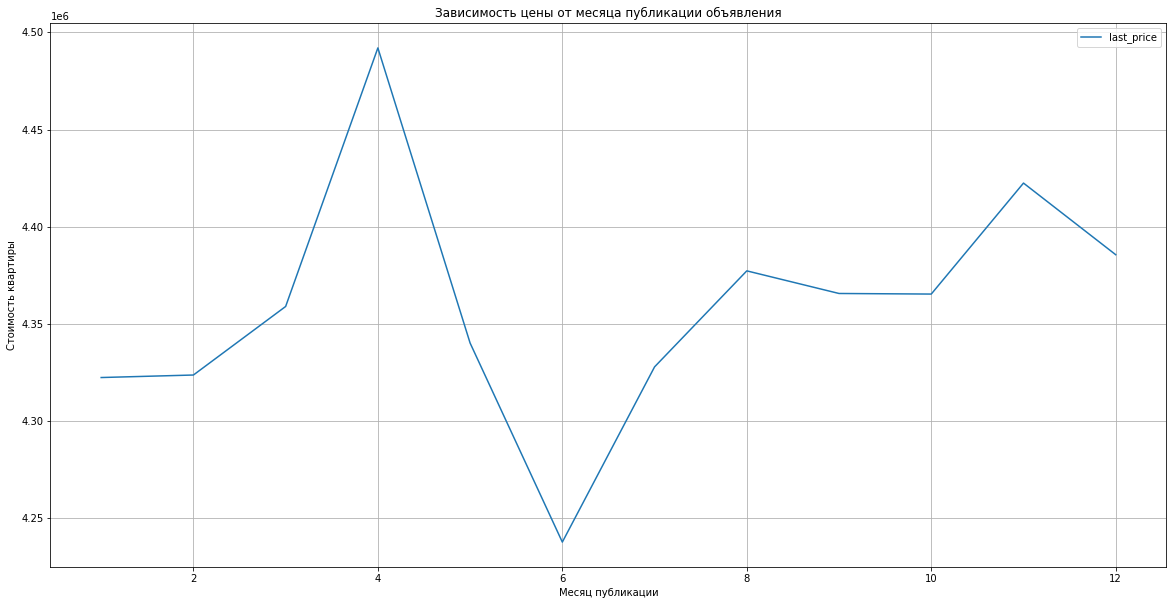

In [101]:
(good_data
    .pivot_table(index='publication_month', values=['last_price'])
    .plot(grid=True, figsize=(20, 10),title='Зависимость цены от месяца публикации объявления'))
plt.xlabel('Месяц публикации')
plt.ylabel('Стоимость квартиры')
plt.show()

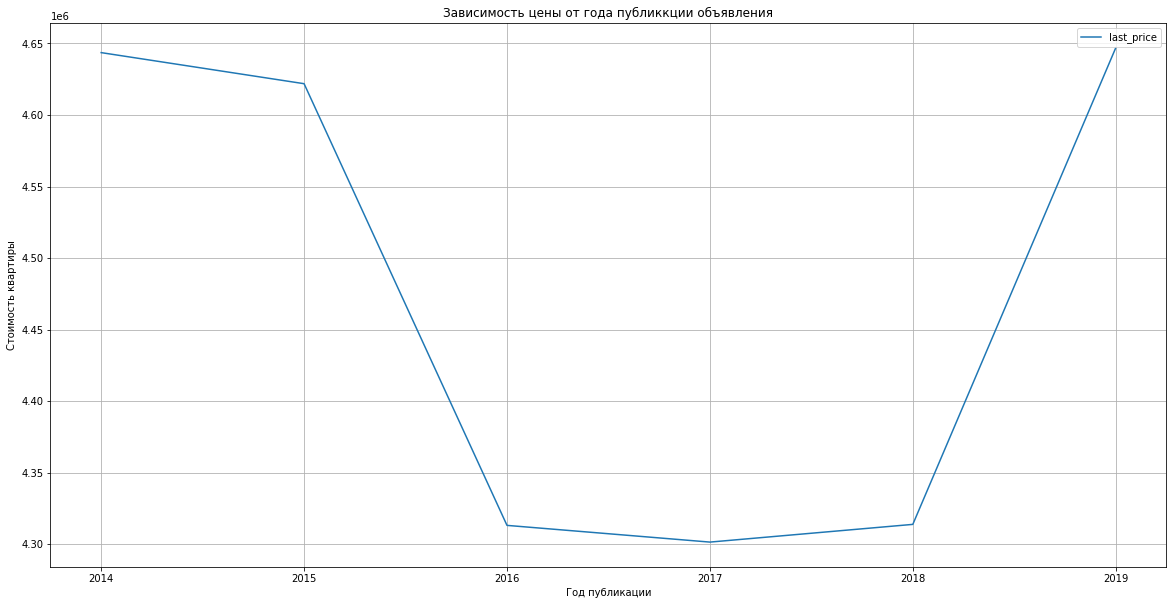

In [102]:
(good_data
    .pivot_table(index='publication_year', values=['last_price'])
    .plot(grid=True, figsize=(20, 10),title='Зависимость цены от года публиккции объявления'))
plt.xlabel('Год публикации')
plt.ylabel('Стоимость квартиры')
plt.show()

Вывод. Выше всего цена продажи квартиры, опубликовнной в апреле, в июне резкий спад цен. Среда и пятница - вот дни, в которые публикуют объявления с высокой ценой продажи. С 2016 по 2018 был спад стоимости жилья, в 2019-м резкий рост, обогнавший цены 2014-2015 годов

In [103]:
a=good_data[['last_price','total_area','floor', "kitchen_area", 'rooms','floors_total','ceiling_height',
             'balcony','days_exposition','parks_nearest','city_centers_nearest']]

In [104]:
a.corr()
# расчитаем корреляцию Пирсона

,last_price,total_area,floor,kitchen_area,rooms,floors_total,ceiling_height,balcony,days_exposition,parks_nearest,city_centers_nearest
last_price,1.000000,0.610966,0.192839,0.357693,0.391867,0.295208,0.200468,0.099550,0.029104,0.070453,-0.277525
total_area,0.610966,1.000000,-0.029146,0.314235,0.808480,-0.015425,0.084446,0.079894,0.084057,0.013297,-0.008037
floor,0.192839,-0.029146,1.000000,0.175563,-0.183712,0.667182,0.205310,0.147057,-0.027999,0.076031,-0.060382
kitchen_area,0.357693,0.314235,0.175563,1.000000,0.030151,0.258257,0.231634,0.139168,0.065056,0.037866,-0.036271
rooms,0.391867,0.808480,-0.183712,0.030151,1.000000,-0.242534,-0.133523,0.015197,0.061871,-0.037684,0.006332
floors_total,0.295208,-0.015425,0.667182,0.258257,-0.242534,1.000000,0.319479,0.139572,-0.032358,0.103131,-0.103785
ceiling_height,0.200468,0.084446,0.205310,0.231634,-0.133523,0.319479,1.000000,0.066154,0.005595,0.043558,-0.093484
balcony,0.099550,0.079894,0.147057,0.139168,0.015197,0.139572,0.066154,1.000000,-0.020873,0.022101,0.022093
days_exposition,0.029104,0.084057,-0.027999,0.065056,0.061871,-0.032358,0.005595,-0.020873,1.000000,0.056144,0.012070
parks_nearest,0.070453,0.013297,0.076031,0.037866,-0.037684,0.103131,0.043558,0.022101,0.056144,1.000000,-0.081797


Расчитали корреляцию между основными параметрами таблицы. Самая высокая корреляция между общей площадью и жилой площадью. Чуть меньше взаимосвязь между площадью квартиры и ее ценой. Практически нет никакой взаимосвязи между расстоянием до парка и ценой. Удивительно, но время продажи квартиры не влияет на ее стоимость

Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений

In [105]:
city_top = data.pivot_table(index='locality_name', values=['first_day_exposition'], aggfunc='count').sort_values(by='first_day_exposition', ascending=False).head(10)
city_top.columns=['number_of_ads']

Создаем таблицу с 10 населенными пунктами, с максимальным количеством объявлений

Больше всего квартир продается в Санкт-Петербурге

In [106]:
city_top["price_metr_mean"] = data.pivot_table(index='locality_name', values=['price_per_meter'], aggfunc='mean').round(2)

In [107]:
city_top  # выводим таблицу для анализа новых данных

,number_of_ads,price_metr_mean
locality_name,,
санкт-петербург,15651,114868.88
поселок мурино,520,85673.26
кудрово,470,95260.85
поселок шушары,439,78551.34
всеволожск,398,68654.47
пушкин,369,103125.82
колпино,338,75424.58
поселок парголово,327,90175.91
гатчина,307,68746.15


Количество объявлений не влияет на среднюю цену метра

In [108]:
city_top["price_metr_mean"].max()

114868.88

In [109]:
city_top["price_metr_mean"].min()

58141.91

Самая высокая стоимость одного квадратного метра жилья в Санкт-Петербурге, на десятом месте г. Выборг 

Изучим объявления в Санкт-Петербурге

In [110]:
in_spb = data.loc[data['locality_name'] == 'санкт-петербург'] # сортируем объявления по СПб

In [111]:
in_spb['city_centers_nearest'].isna().sum() # смотрим количество пропусков в столбце "расстояние до центра"

60

In [112]:
in_spb=in_spb.dropna(subset=['city_centers_nearest']) # удаляем пропуски, тут они не нужны

In [113]:
in_spb['km_to_centre']=(in_spb['city_centers_nearest']/1000).round() #создаем столбец в таблице СПб с расстоянием в км до центра

In [114]:
in_spb.head(3) # проверяем, что получилось

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around,ponds_nearest,days_exposition,price_per_meter,publication_day,publication_month,publication_year,type_floor,distance_center_km,km_to_centre
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,2,755.0,NaN,120370.37,3,3,2019,другой,16.0,16.0
2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.3,4,False,...,2,574.0,558.0,92785.71,3,8,2015,другой,14.0,14.0
3,0,64900000.0,159.0,2015-07-24,3,2.65,14,NaN,9,False,...,3,234.0,424.0,408176.10,4,7,2015,другой,7.0,7.0


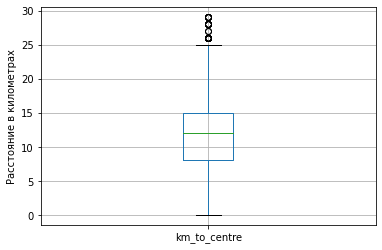

In [115]:
in_spb.boxplot('km_to_centre') 
plt.ylabel('Расстояние в километрах')
plt.show()
# создаем диаграмму размаха

In [116]:
in_spb = in_spb.loc[in_spb['km_to_centre'] < 15] # убираем выделяющиеся значения более 15 км

Расстояние от северной точки Сант-Петербурга до южной точки - 30 км. Соответственно нельзя учитывать объявления за пределами "15 км от центра". Населенные пункты Зеленогорск, Пушкин, Павловск считаются Санкт-Петербургом, но они отдельно выделены. И в этих населенных пунктах своя система ценообразования недвижимости

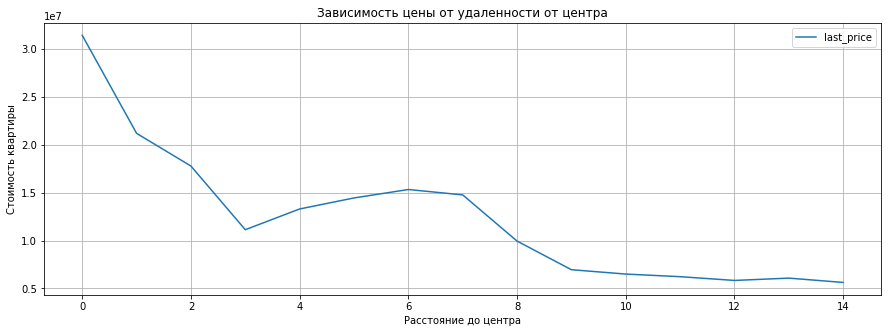

In [117]:
in_spb.pivot_table(index='km_to_centre', values='last_price', aggfunc='mean').plot(figsize=(15,5), grid=True, title='Зависимость цены от удаленности от центра')
plt.xlabel('Расстояние до центра')
plt.ylabel('Стоимость квартиры')
plt.show()

Самая высокая стоимость недвижимости в центре города, чем дальше от центра, тем дешевле. Небольшая просадка есть на расстоянии в 3 километра - это скорее всего связано с наличием промышленных зон, что повлияло на цену

### Общий вывод

ВЫВОД
 
В данном проекте мы анализировали объявления о продаже жилой недвижимости в г. Санкт-Петербурге и Ленинградской области. При первичной обработке данных, столкнулись с большим количеством пропущенных значений в колонках с важными параметрами, которые существенным образом влияют на статистические данные. Пропуски в некоторых колонках удалось заполнить медианными, средними значениями, или нулями. Аномальные, выбивающиеся значения мы удалили, благо их было не много. Следует обратить внимание лиц, ответственных за выгрузку данных о таком положении вещей.
После предобработки данных добавили дополнительные столбцы для анализа (цена 1 кв.м, день, месяц, год публикации объявления, расстояние до центра, тип этажа)

На этапе исследования провели анализ и выявили закономерности в стоимости жилья и площади недвижимости, количестве комнат, этажности). На общую стоимость больше всего влияет количество комнат.(больше комнат - больше площадь) Парки в округе никак не влияют на цену недвиимости. 

Также нами были  проанализировали 10 населенных пунктов с максимальным количеством объявлений.
Лидером, по стоимости недвижимости, является Санкт-Петербург. Но согласно полученным данным стоимость недвижимости в других городах Ленинградской области не сильно отличается от Санкт-Петербурга. По самому Санкт-Петерубргу анализ показал, что стоимость квартир снижается при удалении от центра.


Итого, можно сделать вывод, что в основном продаются 1-2 комнатные квартиры, в 5 или 9 этажных домах с высотой потолка 2.65м. Данные квартиры продаютс за 2-3 месяца. Цена за 1 кв.м. такого жилья составляет 115 т.р. Меньше всего продаж в новостройках на окраине СПб. С 2017 года заметен рост продаж недвижимости, соответсвенно  можно сделать вывод, что в ближайшее время цены на данное жилье будут неуклонно расти.
